This notebook is a rough translation of the learn_wavebring.py CLI. It is only intented to show how the script works and should not be used in a production environment.

In [38]:
# SCRIPT   : wavebreaking
# POURPOSE : identify wave breaking events in timestacks based on machine learn
#            algorithms.
# AUTHOR   : Caio Eadi Stringari
# EMAIL    : Caio.EadiStringari@uon.edu.au
#
# v1.0     : 14/09/2017 [Caio Stringari] - Code base forked from previous
#                                          scripts.
# v2.0     : 05/10/2017 [Caio Stringari] - Major reformulation, included the
#                                          ML steps
# v2.1     : 31/10/2017 [Caio Stringari] - Refine ML portions
# v2.2     : 20/11/2017 [Caio Stringari] - Major reformulation, add JSON I/O
#                                          and edge detection options.

In [39]:
# Imports

from __future__ import print_function, division

# System
import os
import sys

# Arguments
import argparse

# Dates
import time
import datetime
from matplotlib.dates import date2num, num2date

# Numpy
import numpy as np

# Data
import json
import xarray as xr
import pandas as pd

# GIS
import geopandas as gpd
from shapely.geometry import Point

# Peak detection
from peakutils import baseline, envelope, indexes

# Colourspaces
import colour
from colorspacious import deltaE

# distances, fr checking only
from scipy.spatial.distance import __all__ as scipy_dists

# pywavelearn
from pywavelearn.utils import ellapsedseconds, peaklocalextremas
from pywavelearn.image import construct_rgba_vector, pixel_window
from pywavelearn.colour import (get_dominant_colour,
                                classify_colour, colour_quantization)

# Image processing
from skimage.io import imsave
from skimage.color import rgb2grey
from skimage.filters import sobel_h
from skimage.restoration import denoise_bilateral

# Machine learning
from sklearn.cluster import DBSCAN

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Set seaborn
sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks", {'axes.linewidth': 2.0})

Let's set a function to get our analysis locations in the timestack space.

In [41]:
def get_analysis_locations(stk_dist, start, end, step=1):
    """
    Select analysis locations based on the analysis domain and user defined
    step.

    ----------
    Args:
        stk_dist (Mandatory [np.array]): Space array [m].

        start, end (Mandatory [float]): start and end of the spatial domain,
        use get_analysis_domain() to obtain this values.

        step (Optional [int]): skip step. Default is not to skip anything.

    ----------
    Return:
        Y (Mandatory [np.array]): Cross-shore locations in meters.

        Idx (Mandatory [np.array]): Cross-shore locations indexes.
    """
    space_step = step
    Y = []
    Idx = []
    for y in stk_dist[::step]:
        idx = np.argmin(np.abs(stk_dist - y))
        # append only values in the surf zone
        if y > start and y < end:
            Y.append(y)
            Idx.append(idx)
    Y = Y[::-1]
    Idx = Idx[::-1]

    return Y, Idx

And another function to get pixel timeseries data (rgb values) at those locations.

In [42]:
def get_pixel_lines(stk_time, stk, Idx, resample_rule="100L",
                    pxmtc="lightness"):
    """
    Extract pixel timeseries from a given timestack at the locations obtained
    from get_analysis_locations().

    ----------
    Args:
        stk_time (Mandatory [np.array]): array of datetimes.

        stk (Mandatory [np.array]): [time,space,3] timestack array.

        Idx (Mandatory [np.array]): cross-shore indexes obtained from
        get_analysis_locations()

        resample_rule (Optional [str]): Resample frequency. Default is "100L"

        pxmtc (Optional [str]): Pixel metric to use. Default is "lightness"

    ----------
    Returns:
        time (Mandatory [np.array]): Array of datetimes

        dEk (Mandatory [np.array]): [time,Idx] pixel metric array

        RGB (Mandatory [np.array]): [time,Idx,3] colour array
    """

    # case 3D
    if len(stk.shape) == 3:
        RGB = []
        pxint = []
        for idx in Idx:
            # pixel line at exact location
            pxline = stk[:, idx, :]
            # build a dataframe
            df = pd.DataFrame(
                pxline, columns=["red", "green", "blue"], index=stk_time)
            # add grey values
            df["grey"] = pxline.mean(axis=1).astype(np.int)
            # adjust records in time upsampling to 8Hz
            df = df.resample(resample_rule).backfill()
            # df = smoothpixelseries(df, window=5, order=2)
            # compute color parameters
            if pxmtc == "lightness":
                # get rgb values
                rgb = df[["red", "green", "blue"]].values.astype(np.int)
                # exclude invalid values from interpolation
                rgb[rgb < 0] = 0
                # lightness
                pxint.append(deltaE(rgb, [0, 0, 0],
                                    input_space="sRGB255") / 100)
                RGB.append(rgb)
            elif pxmtc == "intensity":
                # get rgb values
                rgb = df[["red", "green", "blue"]].values.astype(np.int)
                # exclude invalid values from interpolation
                rgb[rgb < 0] = 0
                # intensity
                pxint.append(np.mean(rgb))
                RGB.append(rgb)
            else:
                raise NotImplementedError(
                    "Colour metric {} is not valid.".format(pxmtc))
    # case 2D:
    elif len(stk.shape) == 2:
        RGB = []
        pxint = []
        for idx in Idx:
            # pixel line at exact location
            pxline = stk[:, idx]
            # build a dataframe
            df = pd.DataFrame(pxline, columns=["grey"], index=stk_time)
            # adjust records in time upsampling if needed
            df = df.resample(resample_rule).backfill()
            # compute color parameters
            pxint.append(pxline)
            RGB.append([pxline, pxline, pxline])
    else:
        raise ValueError("Image needs to be 2D or 3D.")

    # get times
    time = df.index.to_datetime().to_pydatetime()

    return time, pxint, RGB

Now, let's define the most important function. The wave breaking detection with all the machine learning steps.

In [43]:
def detect_breaking_events(time, crx_dist, rgb, crx_start=None,
                           crx_end=None, px_mtrc="lightness", colours=None,
                           resample_rule="100L", algorithm="peaks",
                           peak_detection="local_maxima", posterize=False,
                           ncolours=0, threshold=0.1, tswindow=11,
                           denoise=True, pxwindow=3, mask_drysand=False):
    """
    Detect wave breaking events. Two main methods are implemented:

    1 - Peak detection: detect wave breaking as lightness peaks in the
                        timestack

        Two peak detection methods are implemented:

        1-a Local maxima. Uses peaklocalextremas() function from pywavelearn
                          to detect local maximas corresponding to wave
                          breaking.

        1-b Differential. Uses the first temporal derivative of the pixel
                          intensity to detect sharp transitions in the
                          timestack that should correspond to wave breaking.

        In both cases, the user can tell to the script to classifiy the
        identified pixel peaks based on known colours. For exemple, water is
        usually blue, sand is brownish and breaking waves are whiteish.
        Only peaks corresponding to wave breakin are append to the output
        structure. This is step done using classifiy_colour()
        from pywavelearn.

    2 - Edge detection: detect wave breaking as sharp edges in the timestack

        Two-options are available:

        2-a Edges only. Wave breaking events are obtained applying a sobel
                        filter to the timestack. Edge locations (time,space)
                        are obrained as:

                        - argument of the maxima (argmax) of a cross-shore
                          pixel intenstiy series obtained at every timestamp.

                        - local maximas of a cross-shore pixel intenstiy series
                          obtained at every timestamp.

        2-b Edges and colours. Wave breaking events are obtained applying a
                               Sobel filter to the timestack and the detected
                               Edges are classified using the colour
                               information as in 1-a. Edge locations
                               (time,space) are obrained as:

                               - argument of the maxima (argmax) of a
                                 cross-shore pixel intenstiy series obtained
                                 at every timestamp.


                               - local maximas of a cross-shore pixel intenstiy
                                 series obtained at every timestamp.
    ----------
    Args:
        time (Mandatory [np.array]): Array of datetimes.

        crx_dist (Mandatory [np.array]): Array of cross-shore locations.

        rgb (Mandatory [np.array]): timestack array.
                                    Shape is [time,crx_dist,3].

        crx_start (Optional [float]): where in the cross-shore orientation to
                                       start the analysis.
                                       Default is crx_dist.min().

        crx_start (Optional [float]): where in the cross-shore orientation to
                                       finish the analysis.
                                       Default is crx_dist.max().

        px_mtrc (Optional [float]): Which pixel intenstiy metric to use.
                                    Default is "lightness".

        resample_rule (Optional [str]): To which frequency interpolate
                                        timeseries Default is  "100L".

        algorithm (Optional [str]): Wave breaking detection algorithm.
                                    Default is "peaks".

        peak_detection (Optional [str]): Peak detection algorithm.
                                         Default is  "local_maxima".

        threshold (Optional [float]): Threshold for peak detection algorithm.
                                      Default is 0.1

        tswindow (Optional [int]): Window for peak detection algorithm.
                                   Default is 11.

        denoise (Optional [bool]): = Denoise timestack using denoise_bilateral
                                     Default is True.

        pxwindow (Optional [int]): Window for denoise_bilateral. Default is 3.

        posterize (Optional [bool]): If true will reduce the number of colours
                                     in the timestack. Default is False.

        ncolours (Optional [str]): Number of colours to posterize.
                                   Default is 16.

        colours (Optional [dict]): A dictionary for the colour learning step.
                                    Something like:
                                    train_colours = {'labels':[0,1,2],
                                                     'aliases':
                                                     ["sand","water","foam"],
                                                     'rgb':[[195,185,155],
                                                            [30,75,75],
                                                            [255,255,255]]
                                                     'target':2}
                                    Default is None.

        mask_drysand (Experimental [bool]) = Mask dry sand using a
                                             colour-temperature (CCT)
                                             relationship. Default is False.
    ----------
    Return:
         time (Mandatory [np.array]): time of occurance of wave breaking
                                      events.

         breakers (Mandatory [np.array]): cross-shore location of wave breaking
                                          events.
    """

    if not crx_start:
        crx_start = crx_dist.min()
        crx_end = crx_dist.max()

    if posterize:
        print("  + >> posterizing")
        rgb = colour_quantization(rgb, ncolours=ncolours)

    # get colour data
    if algorithm == "colour" or algorithm == "edges_and_colour":
        target = colours["target"]
        labels = colours["labels"]
        dom_colours = colours["rgb"]

    # denoise a little bedore computing edges
    if denoise:
        rgb = denoise_bilateral(rgb, pxwindow, multichannel=True)
        # scale back to 0-255
        rgb = (rgb-rgb.min())/(rgb.max()-rgb.min())*255

    # mask sand - Not fully tested
    if mask_drysand:
        # calculate colour temperature
        cct = colour.xy_to_CCT_Hernandez1999(
            colour.XYZ_to_xy(colour.sRGB_to_XYZ(rgb/255)))
        # scale back to 0-1
        cct = (cct-cct.min())/(cct.max()-cct.min())*255
        # mask
        i, j = np.where(cct == 0)
        rgb[i, j, :] = 0

    # detect edges
    if algorithm == "edges" or algorithm == "edges_and_colour":
        print("  + >> calculating edges")
        edges = sobel_h(rgb2grey(rgb))

    # get pixel lines and RGB values at selected locations only
    if algorithm == "peaks" or algorithm == "colour":
        print("  + >> extracting cross-shore pixels")
        Y, crx_idx = get_analysis_locations(crx_dist, crx_start, crx_end)
        Time, PxInts, RGB = get_pixel_lines(time, rgb, crx_idx,
                                            resample_rule=resample_rule,
                                            pxmtc=px_mtrc)

    # get analysis frequency and a 1 sececond time window
    if not tswindow:
        fs = (time[1] - time[0]).total_seconds()
        win = np.int((1 / fs))
    else:
        win = tswindow

    print("  + >> detecting breaking events")
    PeakTimes = []
    print_check = False
    if algorithm == "peaks" or algorithm == "colour":
        if peak_detection == "argmax":
            peak_detection = "local_maxima"
            print("  - >> setting peak detection to local maxima")
        # loop over data rows
        for pxint, rgb in zip(PxInts, RGB):
                # calculate baseline
                bline = baseline(pxint, 2)
                # calculate pixel peaks
                if peak_detection == "local_maxima":
                    _, max_idx = peaklocalextremas(pxint - bline,
                                                   lookahead=win,
                                                   delta=threshold *
                                                   (pxint - bline).max())
                elif peak_detection == "differential":
                        # calculate first derivative
                        pxintdt = np.diff(pxint - bline)
                        # remove values below zero
                        pxintdt[pxintdt <= 0] = 0
                        # scale from 0 to 1
                        pxintdt = pxintdt / pxintdt.max()
                        # get indexes
                        max_idx = indexes(pxintdt, thres=threshold,
                                          min_dist=win)
                else:
                    raise ValueError
                # colour learning step
                if algorithm == "colour":
                    if not print_check:
                        print("  + >> colour learning")
                        print_check = True
                    # classifiy pixels
                    breaker_idxs = []
                    for idx in max_idx:
                        y_pred = classify_colour(rgb[idx], dom_colours, labels)
                        if y_pred[0] == target:
                            breaker_idxs.append(idx)
                # peaks only
                else:
                    breaker_idxs = max_idx
                PeakTimes.append(Time[breaker_idxs])
        # organize peaks and times
        Xpeaks = []
        Ypeaks = []
        for i, pxtimes in enumerate(PeakTimes):
            for v in pxtimes:
                Xpeaks.append(v)
            for v in np.ones(len(pxtimes)) * Y[i]:
                Ypeaks.append(v)
    # edges case
    if algorithm == "edges":
        Xpeaks = []
        Ypeaks = []
        # loop in time
        for i, t in enumerate(time):
            # cross-shore line
            crx_line = edges[i, :]
            # peaks with robust peak detection
            if peak_detection == "differential" or \
               peak_detection == "local_maxima":
                crx_line = (crx_line - crx_line.min()) / (crx_line.max()
                                                          - crx_line.min())
                if not np.all(crx_line == 0):
                    idx_peak = indexes(crx_line,
                                       thres=1-threshold, min_dist=win)
                # apped peaks
                for peak in idx_peak:
                    if crx_dist[peak] > crx_start and crx_dist[peak] < crx_end:
                        Xpeaks.append(t)
                        Ypeaks.append(crx_dist[peak])
            # peaks with simple argmax - works better without colour learning
            else:
                peak = np.argmax(crx_line)
                if crx_dist[peak] > crx_start and crx_dist[peak] < crx_end:
                    Xpeaks.append(t)
                    Ypeaks.append(crx_dist[peak])
    # edges + colour learning case
    if algorithm == "edges_and_colour":
        Ipeaks = []
        Jpeaks = []
        # loop in time
        for i, t in enumerate(time):
            # cross-shore line
            crx_line = edges[i, :]
            if peak_detection == "differential" or \
               peak_detection == "local_maxima":
                crx_line = (crx_line - crx_line.min()) / (crx_line.max()
                                                          - crx_line.min())
                # peaks
                if not np.all(crx_line == 0):
                    idx_peak = indexes(crx_line, thres=1-threshold,
                                       min_dist=win)
                    if not np.all(crx_line == 0):
                        idx_peak = indexes(crx_line, thres=1-threshold,
                                           min_dist=win)
                # apped peaks
                for peak in idx_peak:
                    if crx_dist[peak] > crx_start and crx_dist[peak] < crx_end:
                        Ipeaks.append(i)
                        Jpeaks.append(peak)
            else:
                peak = np.argmax(crx_line)
                if crx_dist[peak] > crx_start and crx_dist[peak] < crx_end:
                    Ipeaks.append(i)
                    Jpeaks.append(peak)
        # colour learning step
        Xpeaks = []
        Ypeaks = []
        for i, j in zip(Ipeaks, Jpeaks):
            if not print_check:
                print("  + >> colour learning")
                print_check = True
            # classify colour
            y_pred = classify_colour(rgb[i, j, :], dom_colours, labels)
            if y_pred[0] == target:
                Xpeaks.append(time[i])
                Ypeaks.append(crx_dist[j])

    # sort values in time and outout
    y = np.array(Ypeaks)[np.argsort(date2num(Xpeaks))]
    x = np.array(Xpeaks)[np.argsort(Xpeaks)]
    
    print("  + >> done!")

    return ellapsedseconds(x), y

And finally, a wrapper around the sk-learn DBSCAN method.

In [44]:
def dbscan(times, breakers, dbs_eps=0.01, dbs_msp=20, dbs_mtc="sqeuclidean"):
    """
    Wrapper around sklearn.cluster.DBSCAN.

    ----------
    Args:
        times (Mandatory [np.array]): array of times (in seconds).

        breakers (Mandatory [np.array]): array of breaker locations
                                         (in meters).

        dbs_eps (Optional [float]): minimum distance for DBSCAN

        dbs_msp (Optional [int]): minimum number of samples for DBSCAN

        dbs_mtc (Optional [str]): which distance metric to use.
    ----------
    Returns:
        df_dbscan (Mandatory [pandas.DataFrame]): DBSCAN results
    """

    # scale data for learning
    xscaled = times / (breakers.max() - breakers.min())
    yscaled = breakers / (times.max() - times.min())
    X = np.vstack([xscaled, yscaled]).T

    # cluster
    db = DBSCAN(eps=dbs_eps, min_samples=dbs_msp, metric=dbs_mtc).fit(X)

    # inliers and outliers
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # dump results into a dataframe
    df_dbscan = pd.DataFrame(np.vstack([times, breakers, labels]).T,
                             columns=["time", "breaker", "wave"])

    return df_dbscan

Now, lets start defining input data and the analysis parameters. In real life, it is done using a hyper-paramter JSON file. Examples are available in the package's documentation.

In [45]:
# input timestack netcdf
ncin = "../data/Stacks/omb_timestack.nc"
# read using xarray
ds = xr.open_dataset(ncin)
print (ds)

<xarray.Dataset>
Dimensions:  (bands: 3, i: 500, j: 500, points: 500, time: 3000, x: 500, y: 500)
Coordinates:
  * x        (x) float64 0.1295 0.4138 0.395 0.3668 0.348 0.3198 0.301 ...
  * y        (y) float64 25.03 25.19 25.31 25.49 25.61 25.79 25.91 26.09 ...
  * i        (i) int64 203 202 202 202 202 202 202 202 202 202 202 202 202 ...
  * j        (j) int64 1269 1266 1264 1261 1259 1256 1254 1251 1249 1246 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bands    (bands) object 'red' 'green' 'blue'
  * time     (time) datetime64[ns] 2014-08-07T09:05:00 ...
Data variables:
    rgb      (time, points, bands) int64 ...


We will need to extract some data to continue the processing.

In [46]:
# coordinates
x = ds["x"].values
y = ds["y"].values
# compute distance from shore
stk_len = np.sqrt(((x.max() - x.min()) * (x.max() - x.min())) +
                  ((y.max() - y.min()) * (y.max() - y.min())))
crx_dist = np.linspace(0, stk_len, len(x))
# get timestack times
stk_time = pd.to_datetime(ds["time"].values).to_pydatetime()
stk_secs = ellapsedseconds(stk_time)
# get RGB values
rgb = ds["rgb"].values

Now, we can define all other the analisys parameters. In the learn_wavebreaking.py script, some of this input can be done via a GUI and the remainder paramters come from the JSON hyper-parameter file.

In [47]:
# define which algorithm is used to detect breaking events
brk_alg = 'colour'
# metric used for pixel intensity definition
px_mtrc = 'lightness'
# colour quantization - We will NOT use this for now
qnt_cl = False
n_clrs = None
# peak detection method
pxp_mtd = 'local_maxima'
# threshold for peak detection
px_trsh = 0.2
# pixel window for denoise_bilateral
px_wndw = 5
# time window for peak detection
ts_wndw = 11
# minimum number of samples to be used for the DBSCAN clustering step
dbs_msp = 15
# minimum distance be used for the DBSCAN clustering step
dbs_eps = 0.0015
# distance metric for the DBSCAN clustering step
dbs_mtc = 'sqeuclidean'

Because we are using the "colour learning" approach, we also need to define some training colours.

In [48]:
# sand colour
sand = [195,185,155]
# water colour
water = [30,75,75]
# foam colour
foam = [250,250,250]
# build colour structure.
# target: 2 indicates that we want to identify only the "foam".
train_colours = {'labels': [0, 1, 2],
                 'aliases': ["sand", "water", "foam"],
                 'rgb': [sand, water, foam],
                 'target': 2}

And to save some compuration time, we also define the cross-shore analysis limits.

In [49]:
crx_start = 15
crx_end = 100

Now, we call the detect_breaking_events() funcion which will learn the wave breaking locations.

In [50]:
times, breakers = detect_breaking_events(stk_time, crx_dist, rgb,
                                         crx_start=crx_start,
                                         crx_end=crx_end,
                                         denoise=False,
                                         tswindow=ts_wndw,
                                         pxwindow=px_wndw,
                                         px_mtrc=px_mtrc,
                                         algorithm=brk_alg,
                                         peak_detection=pxp_mtd,
                                         posterize=qnt_cl,
                                         ncolours=n_clrs,
                                         threshold=px_trsh,
                                         colours=train_colours)

  + >> extracting cross-shore pixels
  + >> detecting breaking events
  + >> colour learning
  + >> done!


We know the wave breaking locations in space and time, but it is a sparce representation. Let's put some order in the chaos using our clustering funcion:

In [51]:
df_dbscan = dbscan(times, breakers, dbs_eps, dbs_msp, dbs_mtc)

Plottting the results:

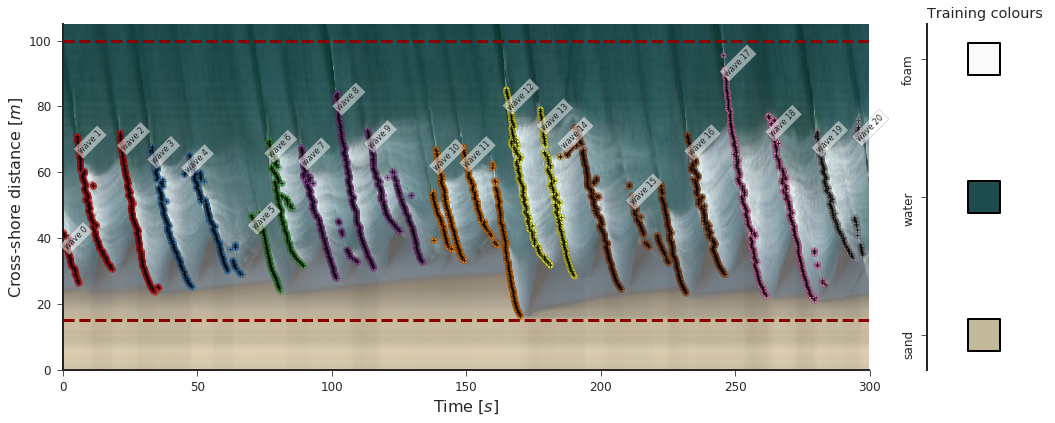

In [52]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.8])
ax2 = fig.add_axes([0.85, 0.1, 0.1, 0.8])

# get unique colours for each wave
colors = plt.cm.get_cmap("Set1",
                         len(np.unique(df_dbscan["wave"].values)))

# get traning colours

for label, region, color in zip(train_colours["labels"],
                                train_colours["aliases"],
                                train_colours["rgb"]):
    ax2.scatter(1, label, 1000, marker="s", color=np.array(color)/255,
                label=region, edgecolor="k", lw=2)
# set axis
ax2.set_yticks(train_colours["labels"])
ax2.set_yticklabels(train_colours["aliases"])
ax2.set_ylim(-0.25, len(train_colours["aliases"])-1+0.25)
for tick in ax2.get_yticklabels():
    tick.set_rotation(90)
ax2.xaxis.set_major_locator(plt.NullLocator())

ax2.set_title("Training colours")

# plot timestack
im = ax1.pcolormesh(stk_secs, crx_dist, rgb.mean(axis=2).T)
# set timestack to  to true color
rgba = construct_rgba_vector(np.rollaxis(rgb, 1, 0), n_alpha=0)
rgba[rgba > 1] = 1
im.set_array(None)
im.set_edgecolor('none')
im.set_facecolor(rgba)

# plot analysis limits
ax1.axhline(y=crx_start, lw=3, color="darkred", ls="--")
ax1.axhline(y=crx_end, lw=3, color="darkred", ls="--")

# plot all identified breaking events
ax1.scatter(times, breakers, 20, color="k", alpha=0.5, marker="+",
            lw=1, zorder=10)

# DBSCAN plot
k = 0
for label, group in df_dbscan.groupby("wave"):
    if label > -1:
        # get x and y for regression
        xwave = group["time"].values
        ywave = group["breaker"].values
        # scatter points
        ax1.scatter(xwave, ywave, 40, label="wave " + str(label),
                    c=colors(k), alpha=0.5, marker="o", edgecolor="k")
        bbox = dict(boxstyle="square",
                    ec="k", fc="w", alpha=0.5)
        ax1.text(xwave.min(), ywave.max(), "wave " + str(k),
                 rotation=45, fontsize=8, zorder=10, bbox=bbox)
        k += 1

# set axes limits
ax1.set_xlim(xmin=stk_secs.min(), xmax=stk_secs.max())
ax1.set_ylim(ymin=crx_dist.min(), ymax=crx_dist.max())

# set axes labels
ax1.set_ylabel(r"Cross-shore distance $[m]$", fontsize=16)
ax1.set_xlabel(r"Time $[s]$", fontsize=16)

# seaborn despine
sns.despine(ax=ax2, bottom=True)
sns.despine(ax=ax1)

plt.show()